In [1]:
import gzip
import json
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import string
import scipy
from sklearn.tree import DecisionTreeClassifier

In [2]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [3]:
%%time
data = []

for l in parse('renttherunway_final_data.json.gz'):
    data.append(l)

CPU times: total: 328 ms
Wall time: 1.22 s


Field Description:

item_id: unique product id

weight: weight measurement of customer

rented for: purpose clothing was rented for

body type: body type of customer

review_text: review given by the customer

review_summary: summary of the review

size: the standardized size of the product

rating: rating for the product

age: age of the customer

category: the category of the product

bust size: bust measurement of customer

height: height of the customer

fit: fit feedback

user_id: a unique id for the customer

review_date: date when the review was written

# Exploratory Analysis

In [4]:
df = pd.DataFrame(data)

In [5]:
clean_df.isna().sum()

NameError: name 'clean_df' is not defined

In [9]:
clean_df = df.copy()

## change weight to number 
clean_df['weight'] = clean_df.weight.str[:-3].astype(float)

## change rating to number
clean_df['rating'] = clean_df.rating.astype(float)

## change height to centimeters
clean_df['height'] = clean_df.height.str.strip('"').str.split('\'').apply(lambda x: (eval(x[0]) * 12 + eval(x[1])) * 2.54 if type(x) == list else x)

## change age
clean_df['age'] = clean_df.age.astype(float)

## change date
clean_df['review_date'] = clean_df['review_date'].astype('datetime64')

## change bust size
clean_df['bust_num'] = clean_df['bust size'].str[:2].astype('float')
clean_df['bust_letter'] = clean_df['bust size'].str[-1]
clean_df = clean_df.drop(columns='bust size')


In [10]:
clean_df.head()

,fit,user_id,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,bust_num,bust_letter
0,fit,420272,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,172.72,14,28.0,2016-04-20,34.0,d
1,fit,273551,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,167.64,12,36.0,2013-06-18,34.0,b
2,fit,360448,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,162.56,4,116.0,2015-12-14,NaN,NaN
3,fit,909926,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,165.10,8,34.0,2014-02-12,34.0,c
4,fit,151944,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,175.26,12,27.0,2016-09-26,34.0,b


In [11]:
## fit value count
df.fit.value_counts()

fit      142058
small     25779
large     24707
Name: fit, dtype: int64

In [12]:
clean_df.groupby('fit').mean()

C:\Users\willi\AppData\Local\Temp\ipykernel_25108\1462026794.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  clean_df.groupby('fit').mean()


,weight,rating,height,size,age,bust_num
fit,,,,,,
fit,137.284831,9.308469,165.912512,12.097249,33.891271,34.198727
large,136.847149,8.551942,165.612294,10.863480,33.565631,34.156102
small,138.498468,8.419615,166.024320,14.384577,34.052262,34.258751


<AxesSubplot: xlabel='rented for'>

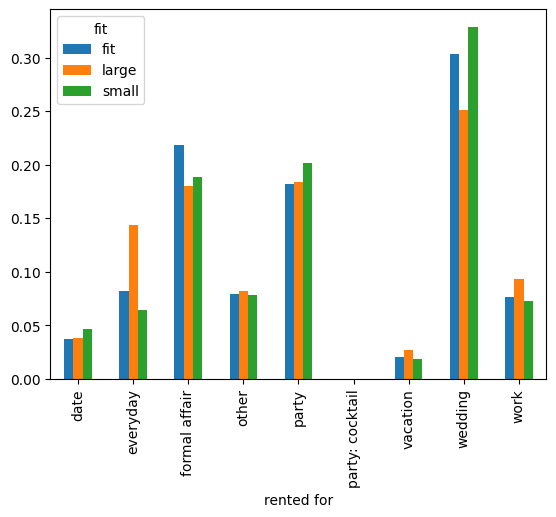

In [13]:
clean_df.groupby('fit')['rented for'].value_counts(normalize = True).unstack().transpose().plot.bar()

<AxesSubplot: xlabel='body type'>

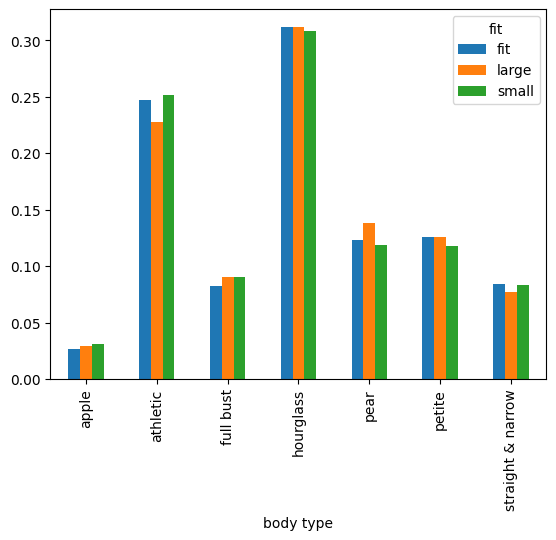

In [14]:
clean_df.groupby('fit')['body type'].value_counts(normalize = True).unstack().transpose().plot.bar()

<AxesSubplot: xlabel='category'>

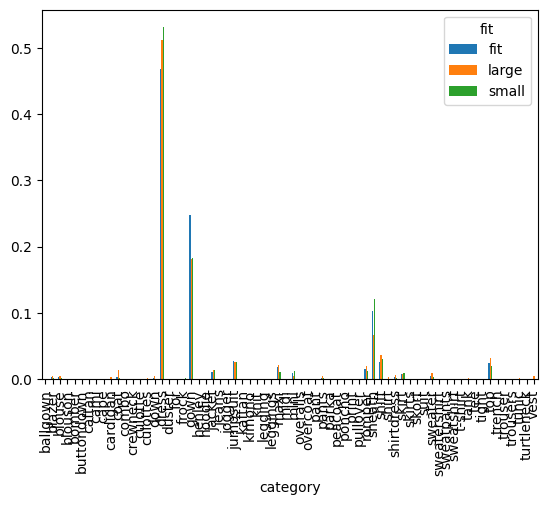

In [15]:
clean_df.groupby('fit')['category'].value_counts(normalize = True).unstack().transpose().plot.bar()

<AxesSubplot: xlabel='bust_letter'>

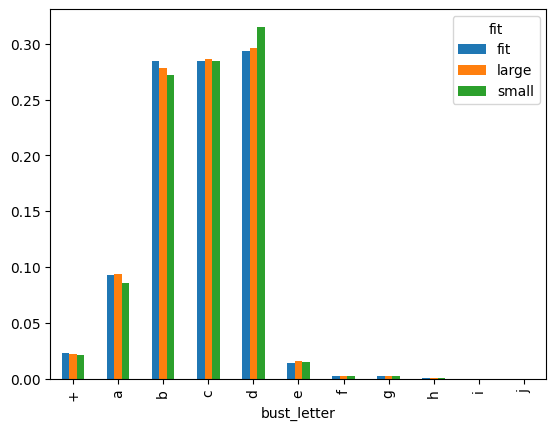

In [16]:
clean_df.groupby('fit')['bust_letter'].value_counts(normalize = True).unstack().transpose().plot.bar()

# Predictive Task

In [17]:
clean_df.shape

(192544, 16)

In [18]:
## test-train split
train = clean_df.iloc[:150000]
test = clean_df.iloc[150000:]

In [19]:
## evaluation index: accuracy
def accuracy(label, predictions):
    return np.mean([a==b for a,b in zip(label, predictions)])

### Baseline Model: Predict Fit Based On Weight and Height

In [20]:
height_info = train.height.describe()
weight_info = test.weight.describe()

height_25 = height_info['25%']
height_75 = height_info['75%']
weight_25 = weight_info['25%']
weight_75 = weight_info['75%']


In [21]:
def baseline_predict(test):
    heights = test.height
    weights = test.weight
    preds = []
    for h, w in zip(heights, weights):
        if h > height_75 and w > weight_75:
            pred = 'small'
        elif h < height_25 and w < weight_25:
            pred = 'large'
        else:
            pred = 'fit'
        preds.append(pred)
    return preds

In [22]:
baseline_predictions = baseline_predict(test)

In [23]:
accuracy(clean_df.fit, baseline_predictions)

0.6470477623166604

In [24]:
np.mean([test.fit == 'fit'])

0.738082925911997

### Model 2: Logistics Regession Using Quantitative Columns as Features

In [25]:
def feature_2(df):
    ## impute missing value by mean value of that variable among data of the same category                                      
    quantitative_col = ['weight', 'rating', 'height', 'size', 'age', 'bust_num', 'review_date']
    X = df[quantitative_col]
    X['Year'] = X['review_date'].apply(lambda x: int(x.year))
    X['Month'] = X['review_date'].apply(lambda x: int(x.month))
    X = X.drop(columns = 'review_date')
    X = X.fillna(X.mean())
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    

    return X

def label_2(df):
    return df['fit']

In [26]:
X_train = feature_2(train)
y_train = label_2(train)

X_test = feature_2(test)
y_test = label_2(test)

C:\Users\willi\AppData\Local\Temp\ipykernel_25108\3525404606.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Year'] = X['review_date'].apply(lambda x: int(x.year))
C:\Users\willi\AppData\Local\Temp\ipykernel_25108\3525404606.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Month'] = X['review_date'].apply(lambda x: int(x.month))
C:\Users\willi\AppData\Local\Temp\ipykernel_25108\3525404606.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [27]:
X_train

array([[-2.01958332e-02,  6.34183148e-01,  1.01249423e+00, ...,
        -1.22060291e-01,  2.34040846e-01, -8.42830285e-01],
       [-2.68559859e-01,  6.34183148e-01,  2.59538276e-01, ...,
        -1.22060291e-01, -2.01164939e+00, -2.51075597e-01],
       [ 1.41178604e-15,  6.34183148e-01, -4.93417674e-01, ...,
         0.00000000e+00, -5.14522565e-01,  1.52418847e+00],
       ...,
       [ 1.41178604e-15,  6.34183148e-01, -4.93417674e-01, ...,
        -1.22060291e-01, -2.01164939e+00, -5.46952941e-01],
       [ 6.25550634e-01, -7.64953912e-01, -4.93417674e-01, ...,
        -1.22060291e-01,  9.82604256e-01, -8.42830285e-01],
       [ 6.25550634e-01,  6.34183148e-01,  1.76545018e+00, ...,
         0.00000000e+00,  9.82604256e-01,  1.22831112e+00]])

In [28]:
clf2 = LogisticRegression()
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
accuracy(y_test, y_pred)

0.7369781872884543

In [29]:
(y_pred == 'fit').mean()

0.9767299736743137

### Model 3: Predict Fit with Categorical Data

In [30]:
clean_df

,fit,user_id,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,bust_num,bust_letter
0,fit,420272,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,172.72,14,28.0,2016-04-20,34.0,d
1,fit,273551,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,167.64,12,36.0,2013-06-18,34.0,b
2,fit,360448,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,162.56,4,116.0,2015-12-14,NaN,NaN
3,fit,909926,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,165.10,8,34.0,2014-02-12,34.0,c
4,fit,151944,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,175.26,12,27.0,2016-09-26,34.0,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,66386,2252812,140.0,10.0,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,175.26,8,42.0,2016-05-18,34.0,d
192540,fit,118398,682043,100.0,10.0,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,154.94,4,29.0,2016-09-30,32.0,c
192541,fit,47002,683251,135.0,6.0,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,172.72,8,31.0,2016-03-04,36.0,a
192542,fit,961120,126335,165.0,10.0,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,167.64,16,31.0,2015-11-25,36.0,c


In [31]:
def feature_3(df, ohe = None):
    cat_col = ['rented for', 'body type', 'category', 'bust_letter']
    cat_df = df[cat_col]
    if ohe == None:
        ohe = OneHotEncoder().fit(cat_df)
    X = ohe.transform(cat_df)
    return X, ohe

In [32]:
X_train, ohe = feature_3(train)
y_train = label_2(train)

X_test, ohe = feature_3(test, ohe)
y_test = label_2(test)

In [33]:
clf2 = LogisticRegression()
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
accuracy(y_test, y_pred)

C:\Users\willi\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.738153441143287

In [34]:
np.mean([y_pred == 'fit'])
#(y_pred == 'large').sum()
#(y_pred == 'small').sum()

0.9997884543061302

### Model 4: Predict Fit with Review Text

In [35]:
train['review_summary']

0                                      So many compliments!
1                                   I felt so glamourous!!!
2         It was a great time to celebrate the (almost) ...
3          Dress arrived on time and in perfect condition. 
4                           Was in love with this dress !!!
                                ...                        
149995    The low back added just the right note of sexy...
149996                                      Very cute dress
149997                  Gorgeous black dress.  Fits well.  
149998                                         Work to play
149999    hits in all the right places!  Super flatterin...
Name: review_summary, Length: 150000, dtype: object

In [36]:
def mostCommonUnigrams(train_data):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    for d in train_data:
        r = ''.join([c for c in d.lower() if not c in punctuation])
        for w in r.split():
            wordCount[w] += 1
    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()
    return counts[:5000]

def mostCommonBigrams(train_data):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    for d in train_data:
        r = ''.join([c for c in d.lower() if not c in punctuation])
        unigrams = r.split()
        bigrams = list(zip(unigrams[:-1], unigrams[1:]))
        bigrams = [' '.join(x) for x in bigrams]
        for w in bigrams:
            wordCount[w] += 1
    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()
    return counts[:5000]

def mostCommonBoth(train_data):
    unigrams = mostCommonUnigrams(train_data)
    bigrams = mostCommonBigrams(train_data)
    both = unigrams + bigrams
    both.sort(key=lambda x: x[0])
    both.reverse()
    return both[:10000]

In [37]:
mostCommonUnigrams(train['review_summary'])
words = mostCommonBoth(train['review_summary'])

In [38]:
def feature_4(datum, words):
    punctuation = set(string.punctuation)
    words = [w[1] for w in words]
    wordId = dict(zip(words, range(len(words))))
    feat = [0]*len(words)
    r = ''.join([c for c in datum.lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    for w in ws + ws2:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat

In [39]:
X_train = [feature_4(d, words) for d in train['review_summary']]
y_train = label_2(train)

X_test =  [feature_4(d, words) for d in test['review_summary']]
y_test = label_2(test)

In [40]:
clf = LogisticRegression(fit_intercept=False)
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
accuracy(y_test, y_preds)

C:\Users\willi\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7529616397141783

In [41]:
np.mean([y_preds == 'fit'])

0.9454447160586686

Review Text

In [42]:
mostCommonUnigrams(train['review_text'])
words = mostCommonBoth(train['review_text'])

In [ ]:
X_train = [feature_4(d, words) for d in train['review_text']]
y_train = label_2(train)

X_test =  [feature_4(d, words) for d in test['review_text']]
y_test = label_2(test)

In [ ]:
clf = LogisticRegression(fit_intercept=False)
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
accuracy(y_test, y_preds)

## Include all features in one pipeline

In [ ]:
def feature_all(df, ohe = None):
    num_df = feature_2(df)
    num_feat = scipy.sparse.csr_matrix(num_df)
    
    cat_feat, ohe = feature_3(df, ohe)
    
    words = mostCommonBoth(train['review_text'])
    text_feat = [feature_4(d, words) for d in df['review_text']]
    text_feat = scipy.sparse.csr_matrix(text_feat)
    
    return scipy.sparse.hstack((num_feat, cat_feat, text_feat)), ohe


In [ ]:
X_train, ohe = feature_all(train)
y_train = label_2(train)

X_test = feature_all(test, ohe)[0]
y_test = label_2(test)

In [ ]:
for c in [0.01, 0.1, 1, 10, 100]:
    clf2 = LogisticRegression(C = c, fit_intercept=False)
    clf2.fit(X_train, y_train)
    y_pred = clf2.predict(X_test)
    print(c, accuracy(y_test, y_pred))